# Live Predictor Example

---

In this notebook, I want to show you how to use a pre-trained model to **predict the direction of price movement in real-time**. In addition, also **trade signals** for buy and sell are generated, based on the direction and derivation values.

For this example, the 1-hour tick data of the BTC-USDT market on Bittrex is used. You can also predict different currencies by just changing the markert name in `TICK_DATA_CURRENT_URL` and `TICK_DATA_PREVIOUS_URL`.

PLEASE BE AWARE: You are running this notebook with an example model, so the signals may be wrong! If you ues them for actual trading, you may loose money!

<br>

The accoring Git Repo can be found under: [The link to the repo](https://github.com/girsigit/CryptoCrystalBall)

In [1]:
TICK_DATA_CURRENT_URL = "https://api.bittrex.com/v3/markets/BTC-USDT/candles/TRADE/HOUR_1/recent"
TICK_DATA_PREVIOUS_URL =  "https://api.bittrex.com/v3/markets/BTC-USDT/candles/TRADE/HOUR_1/historical/{}/{}" #Params: year, month

In [2]:
MODEL_PATH = "https://storage.googleapis.com/cryptocrystalball_public/checkpoints/FPNWithFScaledInput_2/cp_epoch19_batch02000/model.h5"

In [3]:
# Check if the notebook is run in google colab, if so, import some stuff
import sys
import os

colab = 'google.colab' in sys.modules

if colab:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    %cd /content/CryptoCrystalBall/JupyterDocker/notebooks

Running in Colab
/content/CryptoCrystalBall/JupyterDocker/notebooks


In [4]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [6]:
import os
import sys
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import requests

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [7]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = current_dir.split(os.sep)
current_dir_splitted

['', 'content', 'CryptoCrystalBall', 'JupyterDocker', 'notebooks']

In [8]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'DataStreamCreator')
print(f"dsc_dir: {dsc_dir}")

ind_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'IndicatorCalculator')
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [9]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [10]:
# # Define the chart image save path
IMG_SAVE_PATH = "/content"

In [11]:
# Define a global random seed
RANDOM_SEED = 11

# Set the seed in np
np.random.seed(RANDOM_SEED)

# Load the model parameters

In [12]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 512

In [13]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 256

In [14]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 6
MIDSPAN = 48
LONGSPAN = 120

In [15]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used in the pre-trained model
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

In [16]:
# Initiate an IndicatorCalculator instance
indicatorCalculator = IndicatorCalculator(SHORTSPAN, 
                                          MIDSPAN, 
                                          LONGSPAN, 
                                          **DATA_STREAM_PARAMETERS)

---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

It is important to mention that the last timestamp of an X-Block (a frame from the past) matches the timestamp of the y-data entry (lookout into the future of the price).

<br>

As a target value (y data type), the future direction and its derviation of the price have been chosen, as they are easy to visualize and understand.




In [17]:
# Import the required TensorFlow modules
# Todo: Remove unused ones

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization
from keras.layers import Conv1D, Conv2D
from keras.models import Model
from keras.optimizers import Adam

# Import the model
 
It is a Feature-Pyramid based model, pretrained on crypto tick data.

In [18]:
# Download the model file
if not os.path.exists("/content/model.h5"):
  r = requests.get(MODEL_PATH)

  with open("/content/model.h5", 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
      fd.write(chunk)

In [19]:
model = keras.models.load_model("/content/model.h5")
model.summary(line_length=220)

Model: "FPNWithFScaledInput_2"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                           Output Shape                                     Param #                   Connected to                                                             
 inputTicksAndIndicators (InputLayer)                                   [(None, 512, 165)]                               0                         []                                                                       
                                                                                                                                                                                                                            
 UnitNormalizationInput (UnitNormalization)                             (None, 512, 1

---
# Get the live tick data and predict the direction

In [20]:
# Get historical ticks
def GetHourTicksHistorical(monthsBack = 1):
  headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0'
  }

  past_dt = datetime.datetime.utcnow() - datetime.timedelta(days=31*monthsBack)

  u = TICK_DATA_PREVIOUS_URL.format(past_dt.year, past_dt.month)
  r = requests.get(u, headers=headers)
  j = r.json()

  for i in range(len(j)):
    j[i]['startsAt'] = int(datetime.datetime.strptime(j[i]['startsAt'], '%Y-%m-%dT%H:%M:%SZ').timestamp())
  
  if 'code' in j:
      print("Error from API")
      print(j)
      print(u)
      
  df = pd.DataFrame(j)
  df.set_index('startsAt', inplace=True)
  df.sort_index(inplace=True)

  df.drop("quoteVolume", axis=1, inplace=True)

  # Convert tick values from object to numeric
  df = df.apply(pd.to_numeric, errors='coerce')
  
  return df

# GetHourTicksHistorical()

In [21]:
# Get the latest ticks
def GetHourTicksCurrent():
  headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0'
  }

  u = TICK_DATA_CURRENT_URL
  r = requests.get(u, headers=headers)
  j = r.json()

  for i in range(len(j)):
    j[i]['startsAt'] = int(datetime.datetime.strptime(j[i]['startsAt'], '%Y-%m-%dT%H:%M:%SZ').timestamp())
  
  if 'code' in j:
      print("Error from API")
      print(j)
      print(u)
      
  df = pd.DataFrame(j)
  df.set_index('startsAt', inplace=True)
  df.sort_index(inplace=True)

  df.drop("quoteVolume", axis=1, inplace=True)

  # Convert tick values from object to numeric
  df = df.apply(pd.to_numeric, errors='coerce')
  
  return df

# GetHourTicksCurrent()

In [22]:
# Get the ticks
# The latest and two previous months are gathered to ensure there is enough data for stabilizing the indictors and creating X-Blocks 
currentTickDF = GetHourTicksCurrent()
historicalTickDF = GetHourTicksHistorical()
preHistoricalTickDF = GetHourTicksHistorical(2)

tickDF = pd.concat([currentTickDF, historicalTickDF, preHistoricalTickDF])

# Remove duplicated indices
tickDF = tickDF[~tickDF.index.duplicated(keep='first')]

# Sort
tickDF.sort_index(inplace=True)

tickDF

,open,high,low,close,volume
startsAt,,,,,
1667260800,20493.709332,20494.997938,20451.183180,20458.658027,1.537948
1667264400,20459.000000,20550.595460,20459.000000,20504.138440,0.141423
1667268000,20503.892130,20583.624718,20498.012256,20583.624718,0.914401
1667271600,20581.190804,20590.110708,20479.833522,20495.766768,2.085608
1667275200,20478.322182,20515.299696,20463.500000,20502.438283,0.954222
...,...,...,...,...,...
1674352800,22746.818177,22843.700000,22642.402619,22715.830519,2.550244
1674356400,22696.348975,22769.799998,22677.200000,22763.599998,0.119340
1674360000,22768.185051,22871.000000,22745.099998,22840.500000,0.506139


In [23]:
# Calculate the indicators on the tick data
tick_and_indicator_DF = indicatorCalculator.CreateAllIndicatorsTable(tickDF, **DATA_STREAM_PARAMETERS)
tick_and_indicator_DF = indicatorCalculator.NormPriceRelatedIndicators(tick_and_indicator_DF, **DATA_STREAM_PARAMETERS)
tick_and_indicator_DF.dropna(inplace=True)
tick_and_indicator_DF

,ADX120,ADX48,ADX6,ADXR120,ADXR48,ADXR6,APO_12_26,AROONDOWN120,AROONDOWN48,AROONDOWN6,...,low,v_AD,v_ADOSC_48_120,v_ADOSC_6_120,v_ADOSC_6_48,v_MFI120,v_MFI48,v_MFI6,v_OBV,volume
startsAt,,,,,,,,,,,,,,,,,,,,,
1668549600,17.199305,13.364463,24.678208,18.130613,17.572917,37.496407,98.546907,65.833333,14.583333,50.000000,...,-0.002675,-35.159343,-4.067029,-3.036807,1.030222,43.012792,42.187165,43.490513,-268.765099,0.966608
1668553200,17.122455,13.173017,20.964337,18.075485,17.585833,32.875157,83.619906,65.000000,12.500000,33.333333,...,-0.002553,-35.180040,-3.969593,-2.929074,1.040519,43.608191,43.395974,31.451657,-269.012960,0.247861
1668556800,17.050212,12.955257,20.122202,18.028431,17.603415,30.393784,67.095517,64.166667,10.416667,16.666667,...,-0.005976,-36.557162,-3.908447,-3.210262,0.698185,43.546787,44.131859,38.208566,-270.390081,1.377121
1668560400,16.978986,12.738846,19.728014,17.986080,17.630862,26.990705,48.946123,63.333333,8.333333,0.000000,...,-0.001030,-35.037764,-3.811227,-2.983630,0.827596,43.725144,46.563699,43.338455,-268.870683,1.519398
1668564000,16.897056,12.595601,20.887554,17.941848,17.692064,24.898821,35.408114,62.500000,6.250000,0.000000,...,-0.000282,-33.396584,-3.677085,-2.368555,1.308531,44.336754,48.730023,55.051257,-266.107277,2.763406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674352800,23.299029,25.212527,44.305262,25.105633,19.474403,54.767917,155.965673,31.666667,10.416667,100.000000,...,-0.004590,80.100474,9.252917,13.076228,3.823311,57.374835,66.014295,10.485047,-204.517162,2.550244
1674356400,23.324285,25.304092,43.434692,25.106964,19.383709,50.953988,131.202955,30.833333,8.333333,83.333333,...,-0.000844,80.203834,9.163556,12.535587,3.372031,57.152626,66.238958,12.726458,-204.397821,0.119340
1674360000,23.356822,25.434060,37.199191,25.112029,19.309184,45.770162,88.641136,30.000000,6.250000,66.666667,...,-0.001014,80.464743,9.079414,12.166831,3.087417,56.963905,66.616684,18.402383,-203.891682,0.506139


In [24]:
# Feed it into the X-Block generator
xg = DataStreamCreator.XBlockGenerator(tick_and_indicator_DF = tick_and_indicator_DF,
                                       generator_batch_size = 1,
                                       X_Block_lenght = X_BLOCK_LENGHT,
                                       initial_value_norm = False)

# Create an array of all available X-Blocks
# Be aware that the latest tick is not used in X-Block generation, as its OHLCV values may not be stable
XBlockArray = []

while True:
  try:
    XBlock = next(xg)
    XBlockArray.append(XBlock[0,:,:])
  except StopIteration:
    break

XBlockArray = np.array(XBlockArray)

print(XBlockArray.shape)

(1105, 512, 165)


In [25]:
# As each X-Block needs X_BLOCK_LENGHT timesteps for creation, there are this number
# less X-Blocks than timesteps in the tick and indictor DF
tick_and_indicator_DF.shape[0] - XBlockArray.shape[0]

512

In [26]:
# Now lets predict the direction based on these X-Blocks
p = model.predict(XBlockArray, batch_size=32)
p.shape

35/35 [==============================] - 7s 28ms/step


(1105, 2)

In [27]:
# Put direction and derivation in two values for better readability 
p_dir = p[:,0]
p_dir_derivation = p[:,1]

# Plot the results

In [28]:
# Get relevant price data for plotting
tickPlotDF = copy.deepcopy(tickDF)

# X_BLOCK_LENGHT is needed in the beginning to create the first block
tickPlotDF = tickPlotDF.iloc[-p.shape[0]-1:,:]

# The most recent tick is diposed in the XBlock generation process, as it may has unstable OHLCV data
tickPlotDF = tickPlotDF.iloc[:-1,:]

tickPlotDF.shape

(1105, 5)

In [29]:
x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickPlotDF.loc[:,'open'].index]
x_datetimes[-3:]

[datetime.datetime(2023, 1, 22, 3, 0),
 datetime.datetime(2023, 1, 22, 4, 0),
 datetime.datetime(2023, 1, 22, 5, 0)]

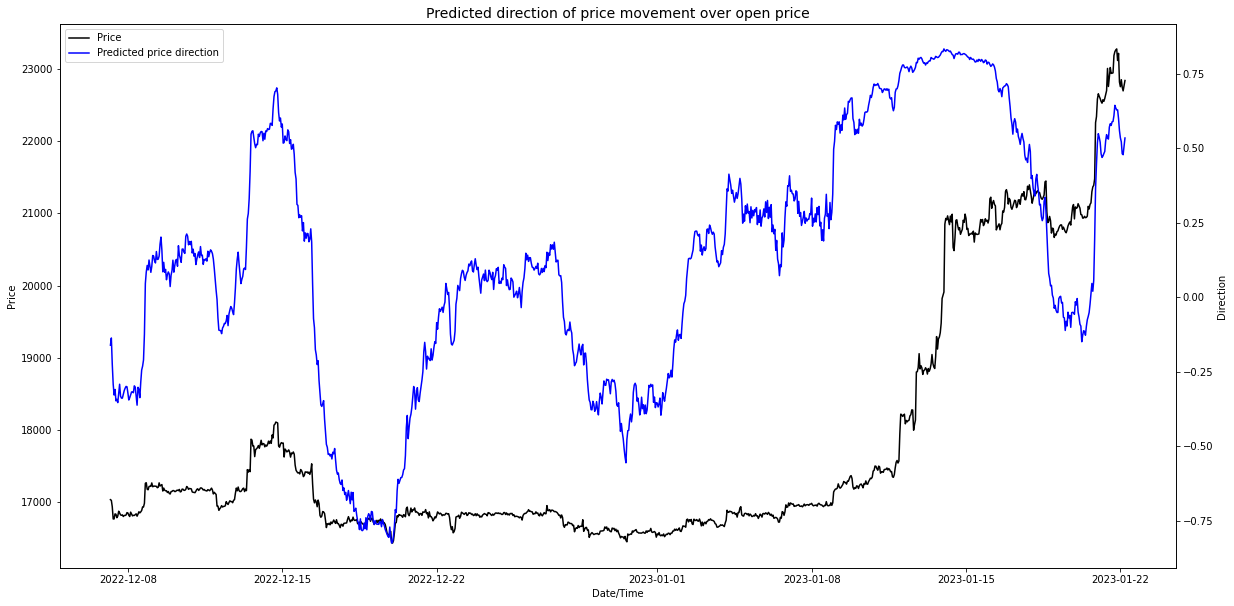

In [30]:
#@title Plot the predicted direction over the price
chart_name="Predicted direction of price movement over open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(x_datetimes, tickPlotDF.loc[:,'open'].values, color="black", label="Price")

_ = ax2 = ax1.twinx()

_ = ax2.plot(x_datetimes, p_dir, color="blue", label="Predicted price direction")

ax1.set_xlabel("Date/Time")
ax1.set_ylabel("Price")
ax2.set_ylabel("Direction")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

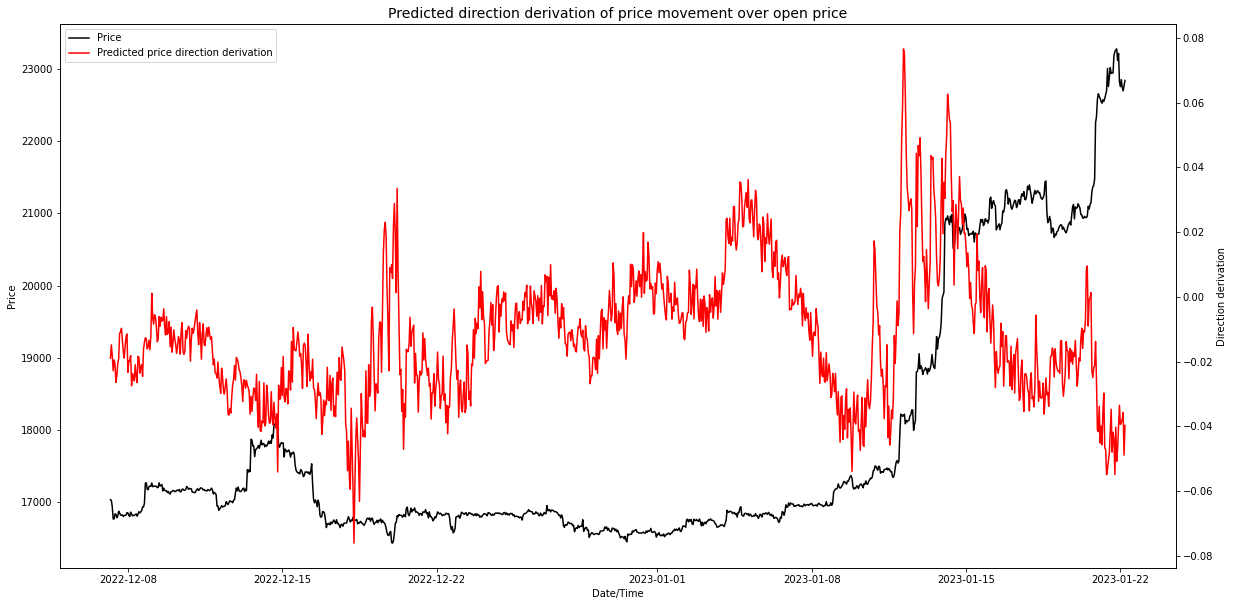

In [31]:
#@title Plot the predicted direction derivation over the price
chart_name="Predicted direction derivation of price movement over open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(x_datetimes, tickPlotDF.loc[:,'open'].values, color="black", label="Price")

_ = ax2 = ax1.twinx()

_ = ax2.plot(x_datetimes, p_dir_derivation, color="red", label="Predicted price direction derivation")

ax1.set_xlabel("Date/Time")
ax1.set_ylabel("Price")
ax2.set_ylabel("Direction derivation")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Plot buy and sell signals

In [32]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_DIR = 0.25 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_DIR_DER = -0.02 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_DIR = 0.0 #@param {type:"number"}

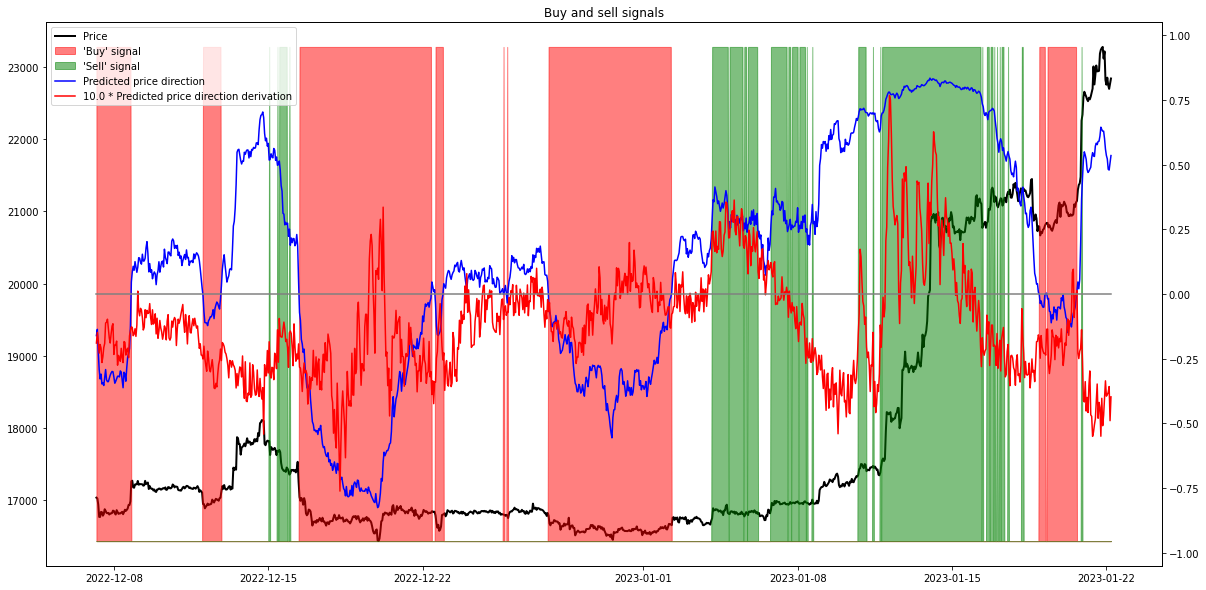

In [33]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

_ = ax1.plot(x_datetimes, tickPlotDF.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_dir < SELL_SIGNAL_THRESHOLD_DIR
yCategoryRise = (p_dir > BUY_SIGNAL_THRESHOLD_DIR) & (p_dir_derivation > BUY_SIGNAL_THRESHOLD_DIR_DER)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_dir, color="blue", label="Predicted price direction")
_ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Plot only recent data

In [34]:
RECENT_HOURS_TO_PLOT = 48

In [35]:
x_datetimes_recent = x_datetimes[-RECENT_HOURS_TO_PLOT:]
p_dir_recent = p_dir[-RECENT_HOURS_TO_PLOT:]
p_dir_derivation_recent = p_dir_derivation[-RECENT_HOURS_TO_PLOT:]
price_recent = tickPlotDF.loc[:,'open'].values[-RECENT_HOURS_TO_PLOT:]

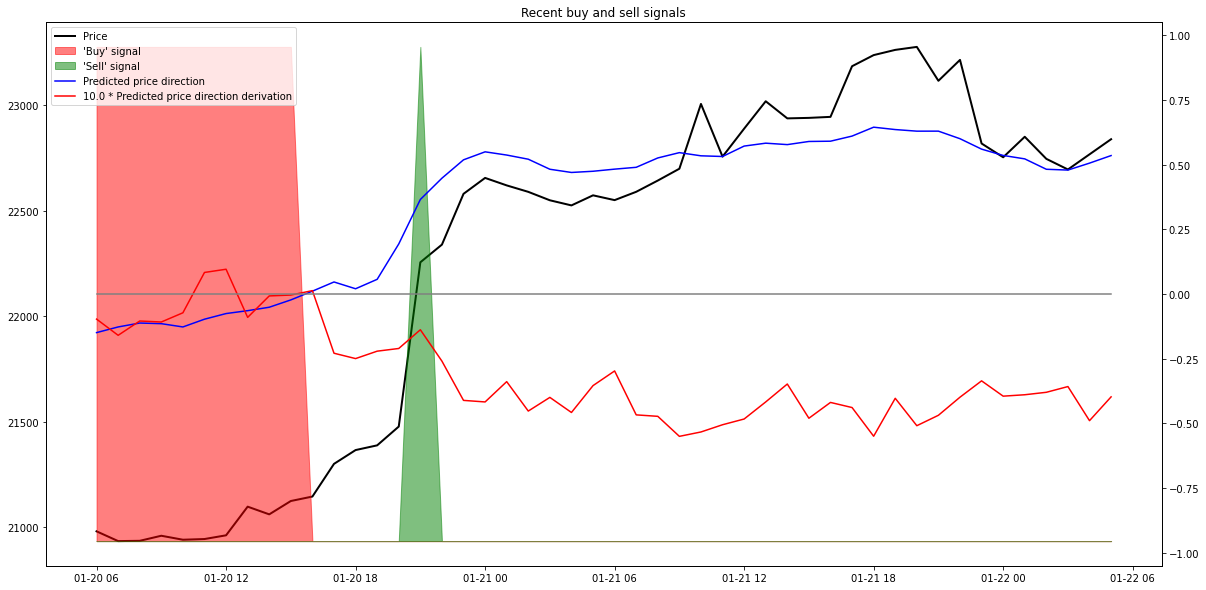

In [36]:
#@title Plot buy and sell signals
chart_name="Recent buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

_ = ax1.plot(x_datetimes_recent, price_recent, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_dir_recent < SELL_SIGNAL_THRESHOLD_DIR
yCategoryRise = (p_dir_recent > BUY_SIGNAL_THRESHOLD_DIR) & (p_dir_derivation_recent > BUY_SIGNAL_THRESHOLD_DIR_DER)

ax2.fill_between(x_datetimes_recent, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes_recent, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes_recent, p_dir_recent, color="blue", label="Predicted price direction")
_ = ax3.plot(x_datetimes_recent, 10.0*p_dir_derivation_recent, color="red", label="10.0 * Predicted price direction derivation")
ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes_recent), np.max(x_datetimes_recent)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Print the latest signal

In [37]:
# Convert the float value prediction into rising and falling categories
yCategoryFall = p_dir < SELL_SIGNAL_THRESHOLD_DIR
yCategoryRise = (p_dir > BUY_SIGNAL_THRESHOLD_DIR) & (p_dir_derivation > BUY_SIGNAL_THRESHOLD_DIR_DER)

if True == yCategoryFall[-1]:
  print("The computer says 'sell'!")
elif True == yCategoryRise[-1]:
  print("The computer says 'buy'!")
else:
  print("The computer says 'stay'!")

The computer says 'stay'!


---
# Conclusion

- Although this is just an example, it already provides interesting signals. Of course they have to be validated and a trading strategy has to be found, but for taking a quick look and a 'second opinion', they already look nice.
- For better signals a to make it sutiable for another market, you can play around with the threshold parameters `BUY_SIGNAL_THRESHOLD_DIR`, `BUY_SIGNAL_THRESHOLD_DIR_DER` and `SELL_SIGNAL_THRESHOLD_DIR`. Of course your can also create new rules, just try it out! Oh, and if you find a good strategy,let me know! :D
- To repeatedly run the notebook on your own computer without the issue of termination of the runtime, download the notebook by clicking 'File -> Download' in the menu. Now you can run it in a local python enviroment forever, for an hourly basis even without a GPU.